<a href="https://colab.research.google.com/github/jhordi19/Ciencia_de_datos/blob/Taller_2025/Taller_Sem10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Cargar librerías y dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Cargar dataset
df = pd.read_csv("dataset_balanceado_smote1.csv")

# Separar variables
X = df.drop("Hypertension", axis=1)
y = df["Hypertension"]

# División entrenamiento/prueba
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###Entrenar Red Neuronal

In [ ]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=0.001,
        learning_rate='adaptive',
        max_iter=500,
        early_stopping=True,
        random_state=42,
        verbose=False
    ))
])

# Entrenar el pipeline
pipeline.fit(x_train, y_train)

# Predecir con datos de prueba (el pipeline escala automáticamente)
y_pred = pipeline.predict(x_test)

# Reporte de clasificación
print("📄 Reporte final - MLPClassifier:")
print(classification_report(y_test, y_pred, target_names=["No Hipertenso", "Hipertenso"]))

📄 Reporte final - MLPClassifier:
               precision    recall  f1-score   support

No Hipertenso       0.76      0.66      0.70      2653
   Hipertenso       0.71      0.80      0.75      2783

     accuracy                           0.73      5436
    macro avg       0.73      0.73      0.73      5436
 weighted avg       0.73      0.73      0.73      5436



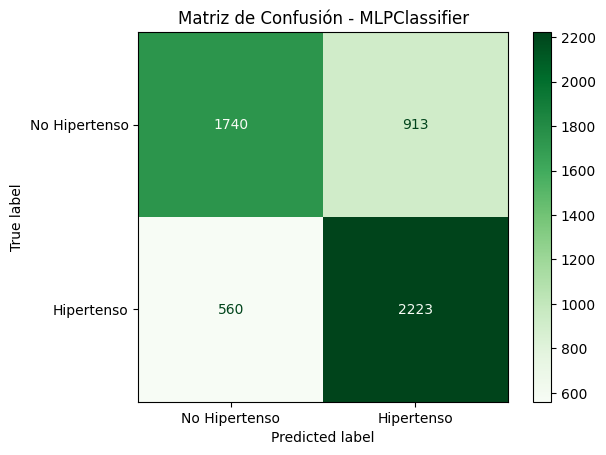

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_mlp = confusion_matrix(y_test, y_pred)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=["No Hipertenso", "Hipertenso"])
disp_mlp.plot(cmap=plt.cm.Greens)
plt.title("Matriz de Confusión - MLPClassifier")
plt.show()

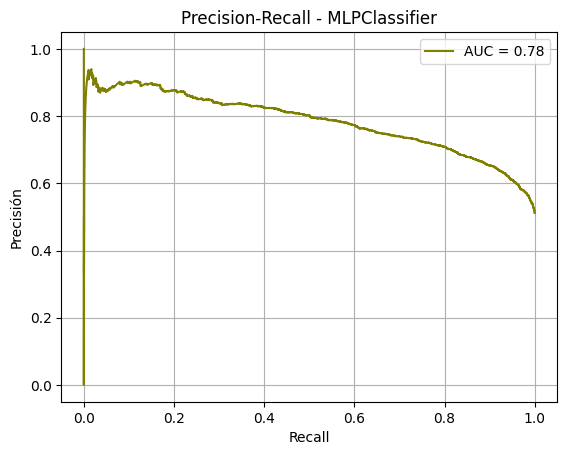

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

y_proba_mlp = pipeline.predict_proba(x_test)[:, 1]
precision_mlp, recall_mlp, _ = precision_recall_curve(y_test, y_proba_mlp)
pr_auc_mlp = auc(recall_mlp, precision_mlp)

plt.figure()
plt.plot(recall_mlp, precision_mlp, color='olive', label=f"AUC = {pr_auc_mlp:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precisión")
plt.title("Precision-Recall - MLPClassifier")
plt.legend()
plt.grid()
plt.show()


###Evaluación (AUC, pérdida, tiempo)


📊 Evaluación para Red Neuronal
✅ AUC-ROC: 0.7987
📉 Log Loss (Entrenamiento): 0.5290
📉 Log Loss (Prueba): 0.5443
⏱️ Tiempo de inferencia promedio: 0.014328 ms


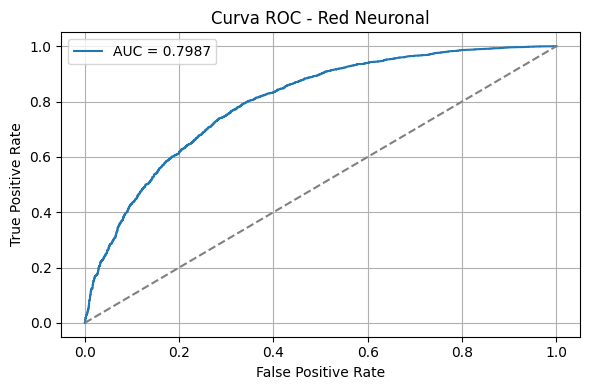

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
import matplotlib.pyplot as plt
import time

def evaluar_red(nombre, modelo, x_train, y_train, x_test, y_test):
    print(f"\n📊 Evaluación para {nombre}")

    y_proba_test = modelo.predict_proba(x_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba_test)
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)

    loss_train = log_loss(y_train, modelo.predict_proba(x_train))
    loss_test = log_loss(y_test, y_proba_test)

    start_time = time.time()
    _ = modelo.predict_proba(x_test)
    end_time = time.time()
    tiempo_prom = (end_time - start_time) / len(x_test) * 1000

    print(f"✅ AUC-ROC: {auc:.4f}")
    print(f"📉 Log Loss (Entrenamiento): {loss_train:.4f}")
    print(f"📉 Log Loss (Prueba): {loss_test:.4f}")
    print(f"⏱️ Tiempo de inferencia promedio: {tiempo_prom:.6f} ms")

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curva ROC - {nombre}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

evaluar_red("Red Neuronal", pipeline, x_train, y_train, x_test, y_test)


###Exportar modelo

In [ ]:
import joblib

# Guarda todo el pipeline: escalador + red neuronal
joblib.dump(pipeline, "modelo_red_neuronal_actualizado.pkl")
print("✅ Red Neuronal exportada como 'modelo_red_neuronal_actualizado.pkl'")

✅ Red Neuronal exportada como 'modelo_red_neuronal_actualizado.pkl'


###Cargar modelo exportado

In [ ]:
import joblib

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

In [ ]:
modelo = joblib.load("modelo_red_neuronal_actualizado.pkl")

In [ ]:
import numpy as np
import joblib

# === 1. Cargar el pipeline completo ===
modelo = joblib.load("modelo_red_neuronal_actualizado.pkl")

# === 2. Datos codificados como en entrenamiento ===
# NOTA: Asegúrate de seguir el mismo orden de columnas
Age = 9
Sex = 0
BMI = 31.25
MentHlth = 6
Salt = 0
PhysActivity = 0
Smoker = 4
Vaper = 4
Alcohol = 1
Diabetes = 1
HighChol = 1

columnas = ['Age', 'Sex', 'BMI', 'Salt', 'PhysActivity', 'Smoker',
            'MentHlth', 'Alcohol', 'Vaper', 'Diabetes', 'HighChol']

x_new_df = pd.DataFrame([[Age, Sex, BMI, MentHlth, Salt, PhysActivity,
    Smoker, Vaper, Alcohol, Diabetes, HighChol]],
                        columns=columnas)

proba = modelo.predict_proba(x_new_df)[0][1]
pred = modelo.predict(x_new_df)[0]

print(f"🔮 Predicción: {pred} (0 = Sano, 1 = Hipertenso)")
print(f"📈 Probabilidad de riesgo: {proba*100:.2f}%")


🔮 Predicción: 1 (0 = Sano, 1 = Hipertenso)
📈 Probabilidad de riesgo: 83.62%
